In [1]:
# Importing the libraries
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from skimage import io, transform


# Setting some hyperparameters
batchSize = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Training Data

Training data contained in data folder.<br>
Scraped images from a google search to replicate football celebrations.<br>
Used the following search terms. <br>

'goal celebration'<br>
'goal scorer celebrate'<br>
'sports celebration'<br>

Really good tutorial on datasets for images in pytorch. <br>
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html <br>

# Data Exploration

In [2]:
def show_image(image):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

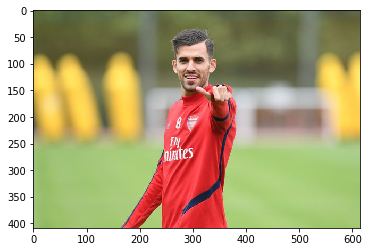

In [3]:
# Lets have a look at one of the images
plt.figure()
show_image(io.imread(os.path.join('data/', '0_Ceballos.jpg')))
plt.show()

In [4]:
# List all the file names of the training data in question
file_list = os.listdir('data/')

# Custom Datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomSizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
goal_dataset = datasets.ImageFolder(root=r'C:\Users\awalker8\Documents\COVID_Furlow\Module 3 - GANs\data',
                                           transform=data_transform)
dataloader = torch.utils.data.DataLoader(goal_dataset,
                                             batch_size=64, shuffle=True,
                                             num_workers=2)

In [6]:
# Defining the weights_init function that takes as input a neural network m and that will initialize all its weights.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [7]:
# Defining the generator

class G(nn.Module): # We introduce a class to define the generator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the generator.
        super(G, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False), # We start with an inversed convolution.
            nn.BatchNorm2d(512), # We normalize all the features along the dimension of the batch.
            nn.ReLU(True), # We apply a ReLU rectification to break the linearity.
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(128), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.BatchNorm2d(64), # We normalize again.
            nn.ReLU(True), # We apply another ReLU.
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias = False), # We add another inversed convolution.
            nn.Tanh() # We apply a Tanh rectification to break the linearity and stay between -1 and +1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output containing the generated images.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the generator defined by self.main.
        return output # We return the output containing the generated images.


In [8]:
# Creating the generator
netG = G() # We create the generator object.
netG.apply(weights_init) # We initialize all the weights of its neural network.

G(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [9]:
# Defining the discriminator

class D(nn.Module): # We introduce a class to define the discriminator.

    def __init__(self): # We introduce the __init__() function that will define the architecture of the discriminator.
        super(D, self).__init__() # We inherit from the nn.Module tools.
        self.main = nn.Sequential( # We create a meta module of a neural network that will contain a sequence of modules (convolutions, full connections, etc.).
            nn.Conv2d(3, 64, 4, 2, 1, bias = False), # We start with a convolution.
            nn.LeakyReLU(0.2, inplace = True), # We apply a LeakyReLU.
            nn.Conv2d(64, 128, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(128), # We normalize all the features along the dimension of the batch.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(128, 256, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(256), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(256, 512, 4, 2, 1, bias = False), # We add another convolution.
            nn.BatchNorm2d(512), # We normalize again.
            nn.LeakyReLU(0.2, inplace = True), # We apply another LeakyReLU.
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), # We add another convolution.
            nn.Sigmoid() # We apply a Sigmoid rectification to break the linearity and stay between 0 and 1.
        )

    def forward(self, input): # We define the forward function that takes as argument an input that will be fed to the neural network, and that will return the output which will be a value between 0 and 1.
        output = self.main(input) # We forward propagate the signal through the whole neural network of the discriminator defined by self.main.
        return output.view(-1) # We return the output which will be a value between 0 and 1.


In [10]:
# Creating the discriminator
netD = D() # We create the discriminator object.
netD.apply(weights_init) # We initialize all the weights of its neural network.


D(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [11]:
# Training the DCGANs

criterion = nn.BCELoss() # We create a criterion object that will measure the error between the prediction and the target.
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the discriminator.
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999)) # We create the optimizer object of the generator.


In [12]:
for epoch in range(1): # We iterate over ... epochs.

    for i, data in enumerate(dataloader, 0): # We iterate over the images of the dataset.
        
        # 1st Step: Updating the weights of the neural network of the discriminator

        netD.zero_grad() # We initialize to 0 the gradients of the discriminator with respect to the weights.
        # Training the discriminator with a real image of the dataset
        real, _ = data # We get a real image of the dataset which will be used to train the discriminator.
        input = Variable(real) # We wrap it in a variable.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(input) # We forward propagate this real image into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_real = criterion(output, target) # We compute the loss between the predictions (output) and the target (equal to 1).
        
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(input.size()[0], 100, 1, 1)) # We make a random input vector (noise) of the generator.
        fake = netG(noise) # We forward propagate this random input vector into the neural network of the generator to get some fake generated images.
        target = Variable(torch.zeros(input.size()[0])) # We get the target.
        output = netD(fake.detach()) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errD_fake = criterion(output, target) # We compute the loss between the prediction (output) and the target (equal to 0).

         # Backpropagating the total error
        errD = errD_real + errD_fake # We compute the total error of the discriminator.
        errD.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the discriminator.
        optimizerD.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the discriminator.

        
        # 2nd Step: Updating the weights of the neural network of the generator

        netG.zero_grad() # We initialize to 0 the gradients of the generator with respect to the weights.
        target = Variable(torch.ones(input.size()[0])) # We get the target.
        output = netD(fake) # We forward propagate the fake generated images into the neural network of the discriminator to get the prediction (a value between 0 and 1).
        errG = criterion(output, target) # We compute the loss between the prediction (output between 0 and 1) and the target (equal to 1).
        errG.backward() # We backpropagate the loss error by computing the gradients of the total error with respect to the weights of the generator.
        optimizerG.step() # We apply the optimizer to update the weights according to how much they are responsible for the loss error of the generator.
        
        # 3rd Step: Printing the losses and saving the real images and the generated images of the minibatch every 100 steps

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), errD.data.item(), errG.data.item())) # We print les losses of the discriminator (Loss_D) and the generator (Loss_G).
        if i % 500 == 0: # Every 100 steps:
            vutils.save_image(real, '%s/real_celebrations.png' % "./results", normalize = True) # We save the real images of the minibatch.
            fake = netG(noise) # We get our fake generated images.
            vutils.save_image(fake.data, '%s/fake_celebrate%03d.png' % ("./results", epoch), normalize = True) # We also save the fake generated images of the minibatch.


[0/25][0/18] Loss_D: 1.6786 Loss_G: 7.3863
[0/25][1/18] Loss_D: 1.0901 Loss_G: 3.8818
[0/25][2/18] Loss_D: 1.6999 Loss_G: 5.8350
[0/25][3/18] Loss_D: 1.0722 Loss_G: 6.7603
[0/25][4/18] Loss_D: 0.7474 Loss_G: 6.2254
[0/25][5/18] Loss_D: 1.3609 Loss_G: 6.8388
[0/25][6/18] Loss_D: 1.3782 Loss_G: 8.2227
[0/25][7/18] Loss_D: 1.1274 Loss_G: 7.4746
[0/25][8/18] Loss_D: 1.2984 Loss_G: 8.0592
[0/25][9/18] Loss_D: 0.8586 Loss_G: 7.8856
[0/25][10/18] Loss_D: 0.7820 Loss_G: 10.1128
[0/25][11/18] Loss_D: 0.5322 Loss_G: 8.7821
[0/25][12/18] Loss_D: 1.0510 Loss_G: 11.4856
[0/25][13/18] Loss_D: 0.6524 Loss_G: 8.1978
[0/25][14/18] Loss_D: 1.7441 Loss_G: 12.9991
[0/25][15/18] Loss_D: 0.4652 Loss_G: 9.4993
[0/25][16/18] Loss_D: 2.0423 Loss_G: 13.5984
[0/25][17/18] Loss_D: 0.9308 Loss_G: 9.8179
